Using /tmp/torch_extensions as PyTorch extensions root...
No modifications detected for re-loaded extension module gp_interp_cuda, skipping build step...
Loading extension module gp_interp_cuda...
Num coords: 129600
Doing a forward pass...
Doing a backward pass...
Loss: 0.0144024807959795
Success!


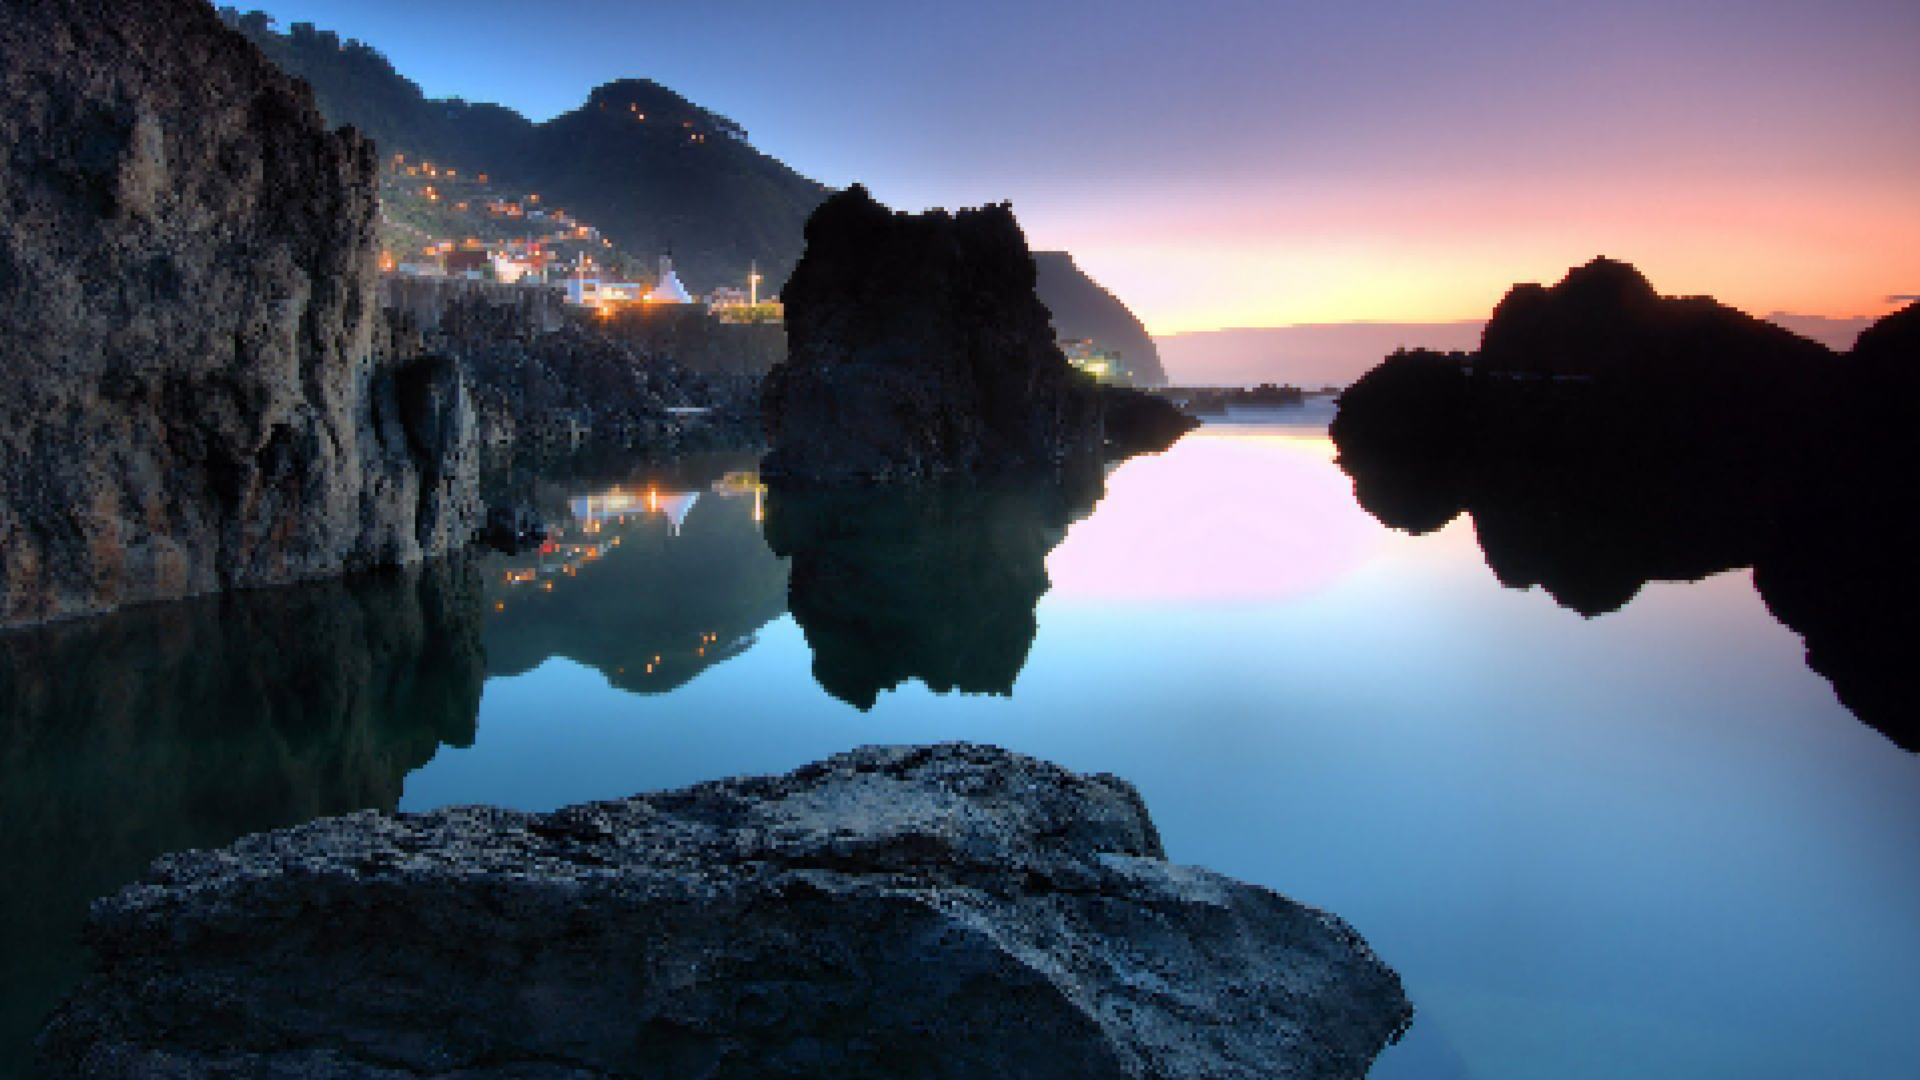

In [21]:
from torch.utils.cpp_extension import load

gp_interp_cuda = load('gp_interp_cuda', ['gp_interp_cuda.cpp', 'gp_interp_cuda_kernel.cu'], verbose=True)

import sys; sys.path.extend(['.', '../cuda'])

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TVF

from gp_interp import GPInterp

device = 'cuda'
# img_pil = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')
img_pil = Image.open('./water.jpg')
img = TVF.to_tensor(img_pil).to(device)
gp = GPInterp(img.shape[1], img.shape[2], img.shape[0], 0.25, 1.0, 5)
gp.to(device)

print('Num coords:', len(gp.means))

print('Doing a forward pass...')
out = gp(img)

print('Doing a backward pass...')
loss = (out - img).abs().mean()
loss.backward()
print('Loss:', loss.item())
print('Success!')

TVF.to_pil_image(out.cpu())

In [104]:
tqdm._instances.clear()

In [ ]:
from tqdm import tqdm

gp = GPInterp(img.shape[1], img.shape[2], img.shape[0], 0.2, 2.5, 5)
gp.to(device)
means_old = gp.means.data.cpu().tolist()
optim = torch.optim.SGD(gp.parameters(), lr=0.000001)
# optim = torch.optim.Adam(gp.parameters(), lr=0.0001, betas=(0.5, 0.98))

for i in tqdm(range(500)):
    out = gp(img)
    loss = (out - img).pow(2).mean()
    optim.zero_grad()
    loss.backward()
    #torch.nn.utils.clip_grad_value_(gp.parameters(), 1.0)
    optim.step()
    if i % 100 == 0:
        print(f'{loss.item():.05f}')
        
print('diff passed:', (torch.tensor(means_old).to(device) - gp.means).abs().mean())

  6%|▌         | 30/500 [00:00<00:03, 145.57it/s]

0.00111


 24%|██▍       | 120/500 [00:00<00:02, 146.92it/s]

0.00111


 45%|████▌     | 225/500 [00:01<00:01, 147.86it/s]

0.00111


 51%|█████     | 255/500 [00:01<00:01, 148.06it/s]

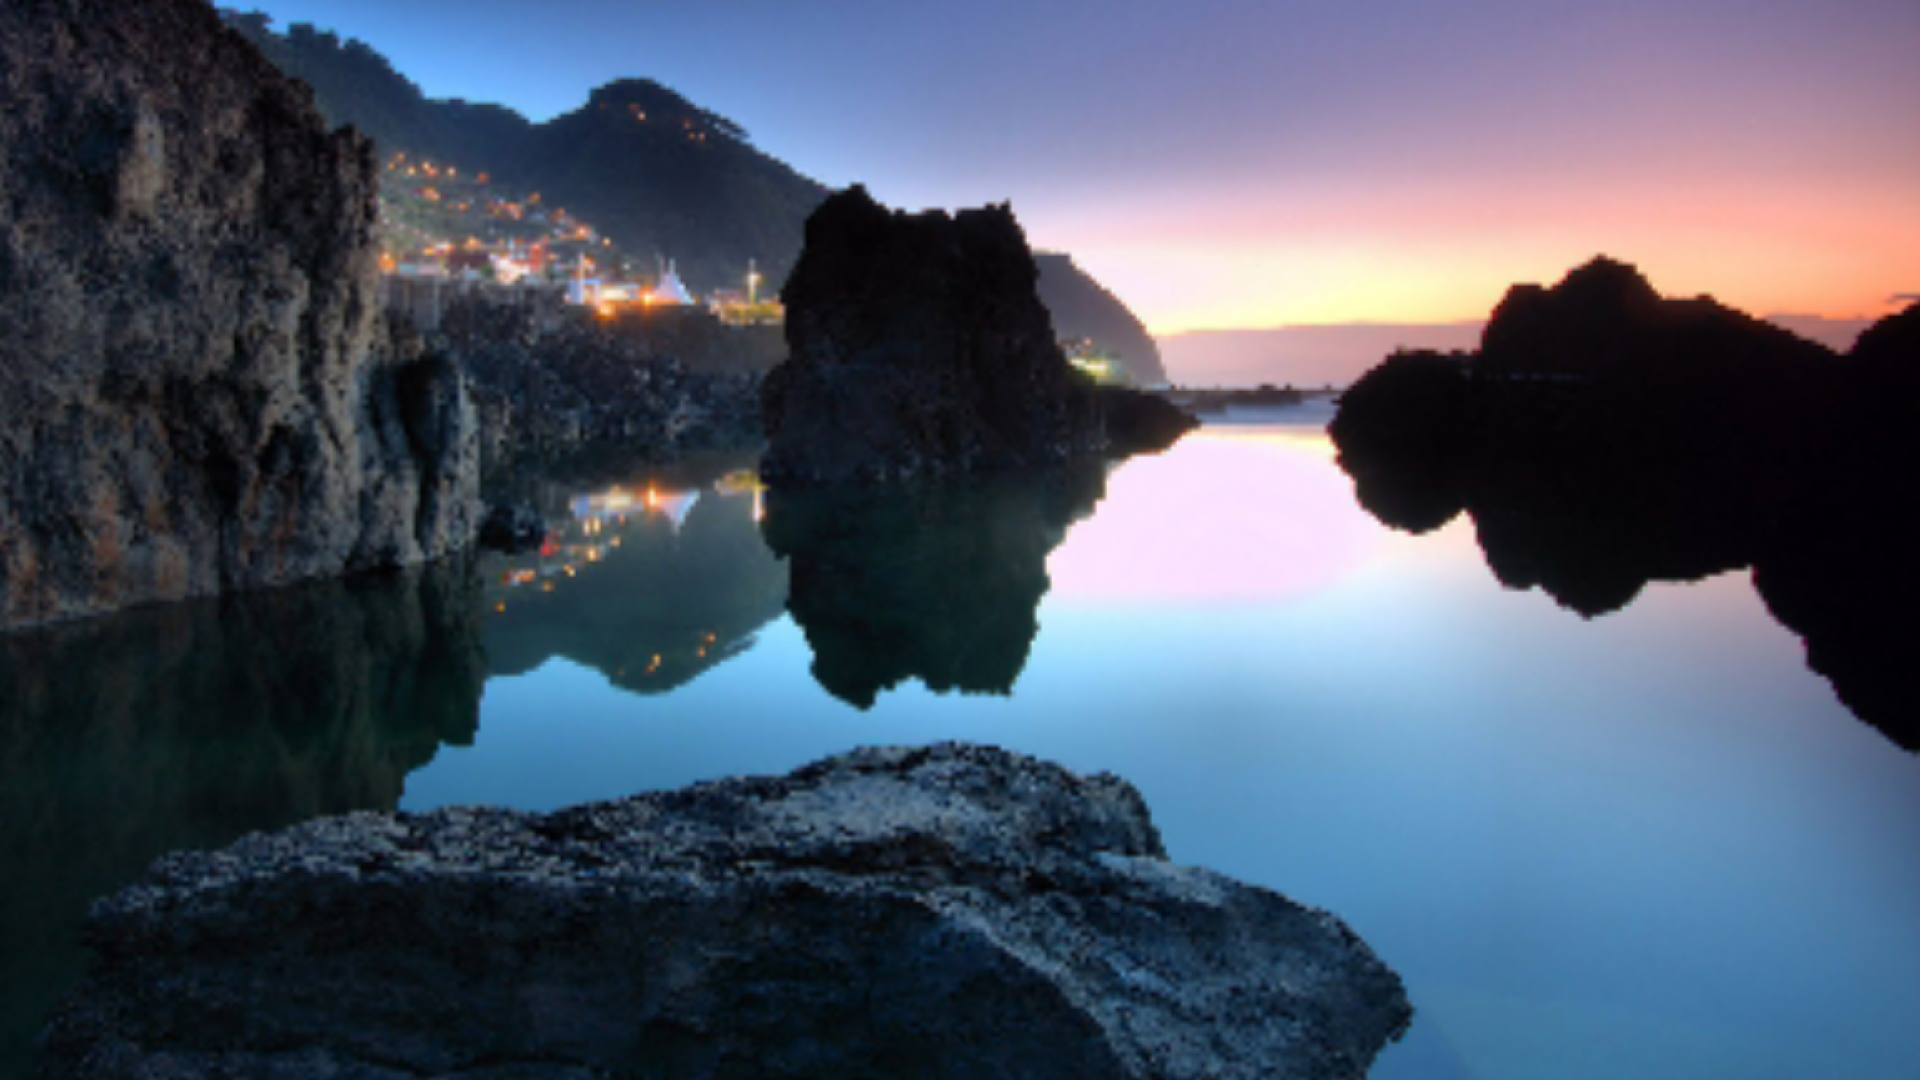

In [102]:
TVF.to_pil_image(out.cpu())